<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Market-segmentation-with-unsupervised-learning" data-toc-modified-id="Market-segmentation-with-unsupervised-learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Market segmentation with unsupervised learning</a></span><ul class="toc-item"><li><span><a href="#Products-Clustering" data-toc-modified-id="Products-Clustering-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Products Clustering</a></span><ul class="toc-item"><li><span><a href="#Products-Description" data-toc-modified-id="Products-Description-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Products Description</a></span></li><li><span><a href="#Defining-product-categories" data-toc-modified-id="Defining-product-categories-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Defining product categories</a></span></li><li><span><a href="#Data-encoding" data-toc-modified-id="Data-encoding-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Data encoding</a></span><ul class="toc-item"><li><span><a href="#Creating-clusters-of-products" data-toc-modified-id="Creating-clusters-of-products-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Creating clusters of products</a></span></li></ul></li><li><span><a href="#Characterizing-the-content-of-clusters" data-toc-modified-id="Characterizing-the-content-of-clusters-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Characterizing the content of clusters</a></span></li></ul></li></ul></li><li><span><a href="#Customer-categories" data-toc-modified-id="Customer-categories-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Customer categories</a></span><ul class="toc-item"><li><span><a href="#Formatting-data¶" data-toc-modified-id="Formatting-data¶-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Formatting data¶</a></span></li><li><span><a href="#Creation-of-customers-categories" data-toc-modified-id="Creation-of-customers-categories-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creation of customers categories</a></span><ul class="toc-item"><li><span><a href="#Data-encoding" data-toc-modified-id="Data-encoding-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Data encoding</a></span></li></ul></li><li><span><a href="#Inspect-the-clusters-with-boxplot" data-toc-modified-id="Inspect-the-clusters-with-boxplot-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inspect the clusters with boxplot</a></span></li><li><span><a href="#Hierarchical" data-toc-modified-id="Hierarchical-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Hierarchical</a></span></li><li><span><a href="#Test-Set" data-toc-modified-id="Test-Set-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Test Set</a></span></li></ul></li></ul></div>

# Market segmentation with unsupervised learning


## Products Clustering
We noticed that there's diversified products in the market, and Description variable shows a short description of the products. Our study put products with similar description into same group and divided products in whole market into 5 groups with K-means. 



### Products Description
As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

In [1]:
### install package 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
import nltk


In [121]:
### load data
nltk.download('punkt')
### load saved data 'data_cleaned.csv'
df_cleaned=pd.read_csv('data_cleaned.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str},index_col=0)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

[nltk_data] Downloading package punkt to /Users/shaoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

In [122]:
is_noun = lambda pos: pos[:2] == 'NN'
nltk.download('averaged_perceptron_tagger')
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shaoqi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
train_FRM=pd.read_csv('data_RFM_train.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str},index_col=0)

The execution of this function returns three variables:

**keywords**: the list of extracted keywords

**keywords_roots**: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots

**count_keywords**: dictionary listing the number of times every word is used


In [5]:
df_produits = pd.DataFrame(df_cleaned['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


In [6]:
df_produits

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3891,"LETTER ""W"" BLING KEY RING"
3892,"LETTER ""Z"" BLING KEY RING"
3893,PINK CRYSTAL SKULL PHONE CHARM
3894,CREAM HANGING HEART T-LIGHT HOLDER


At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [7]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

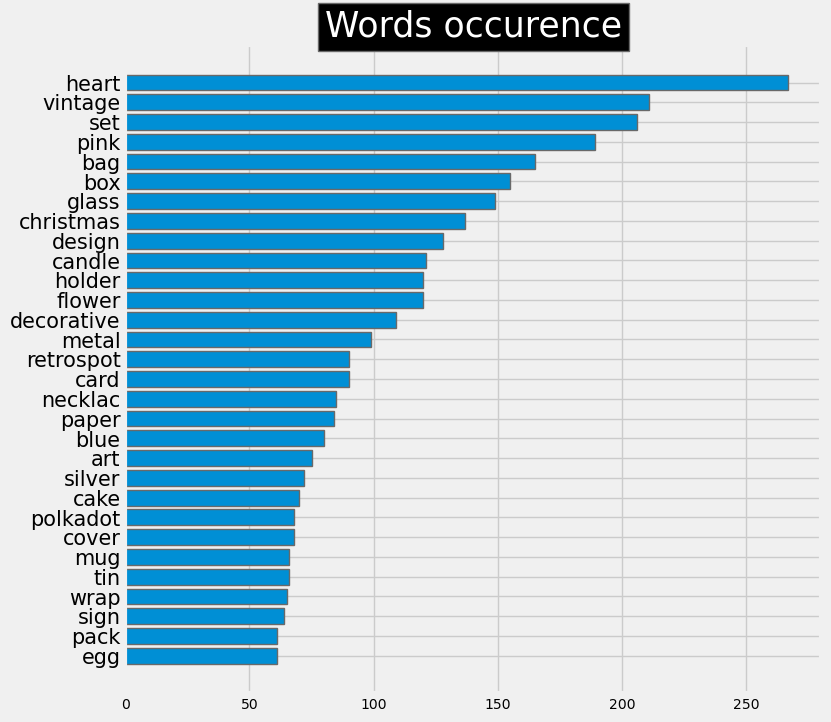

In [8]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(8, 8))
y_axis = [i[1] for i in liste[:30]]
x_axis = [k for k,i in enumerate(liste[:30])]
x_label = [i[0] for i in liste[:30]]
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 15)
plt.yticks(x_axis, x_label)
#plt.xlabel("Nb. of occurences", fontsize = 15, labelpad = 5)
ax.barh(x_axis, y_axis, align = 'center',)
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [9]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots have a shared x-axis along a column, on

### Defining product categories

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. 
However, not all the words in the list is useful and helpful for our study.
Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [10]:
# The most frequent ones appear in more than 200 products. 
# We removed color and only consider words that appear more than 13 times.
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange','design','art']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)

### Data encoding
Now I will use these keywords to create groups of product. Firstly, I define the  X
matrix as
   
|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [11]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

The  X
  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [12]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [13]:
print("{:<8} {:<20} \n".format('gamme', 'nb. products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. products         
--------------------
0<.<1       965                 
1<.<2       1013                
2<.<3       674                 
3<.<5       611                 
5<.<10      476                 
.>10        157                 


#### Creating clusters of products
In this section, we will try to cluster the diversified product.
We leverage K means to do clustering with these products and use silhouette_score to measure the quality of oue cluster.

In [14]:
matrix = X.values
for n_clusters in range(2,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=50,random_state=150,algorithm="elkan")
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.07223906305301783
For n_clusters = 3 The average silhouette_score is : 0.1045648588383922
For n_clusters = 4 The average silhouette_score is : 0.13100158410240928
For n_clusters = 5 The average silhouette_score is : 0.15216615922254736
For n_clusters = 6 The average silhouette_score is : 0.1563527847672917
For n_clusters = 7 The average silhouette_score is : 0.16472111528569278
For n_clusters = 8 The average silhouette_score is : 0.1431407661286799
For n_clusters = 9 The average silhouette_score is : 0.1229410566320703
For n_clusters = 10 The average silhouette_score is : 0.17157328605701802
For n_clusters = 11 The average silhouette_score is : 0.1418073254408623
For n_clusters = 12 The average silhouette_score is : 0.14696508835397615
For n_clusters = 13 The average silhouette_score is : 0.13326175938356208
For n_clusters = 14 The average silhouette_score is : 0.10402335603870223


In [15]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15293722395307302


### Characterizing the content of clusters

In [16]:
pd.Series(clusters).value_counts()

2    1013
1     965
3     674
4     633
0     611
dtype: int64

**a / _Silhouette intra-cluster score_**

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):


In [17]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

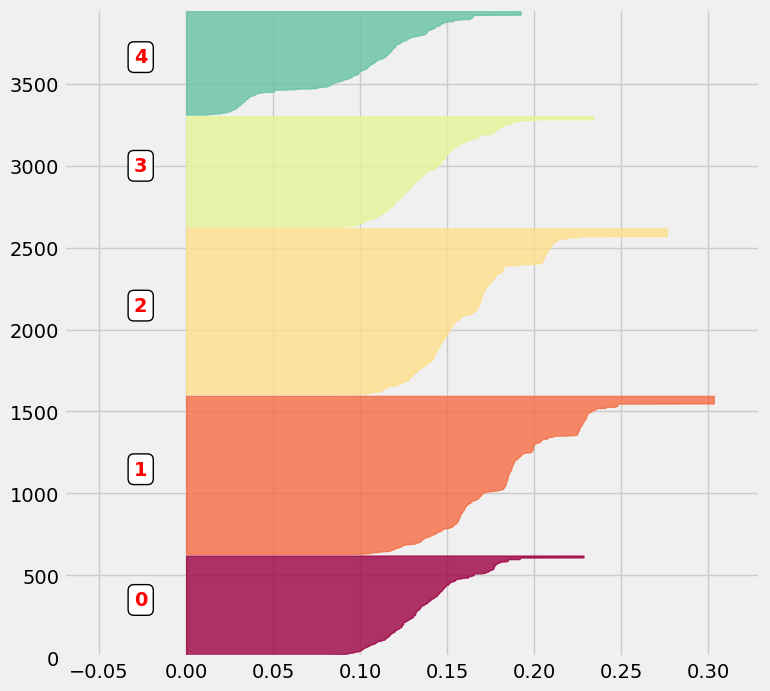

In [18]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [19]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

**b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them


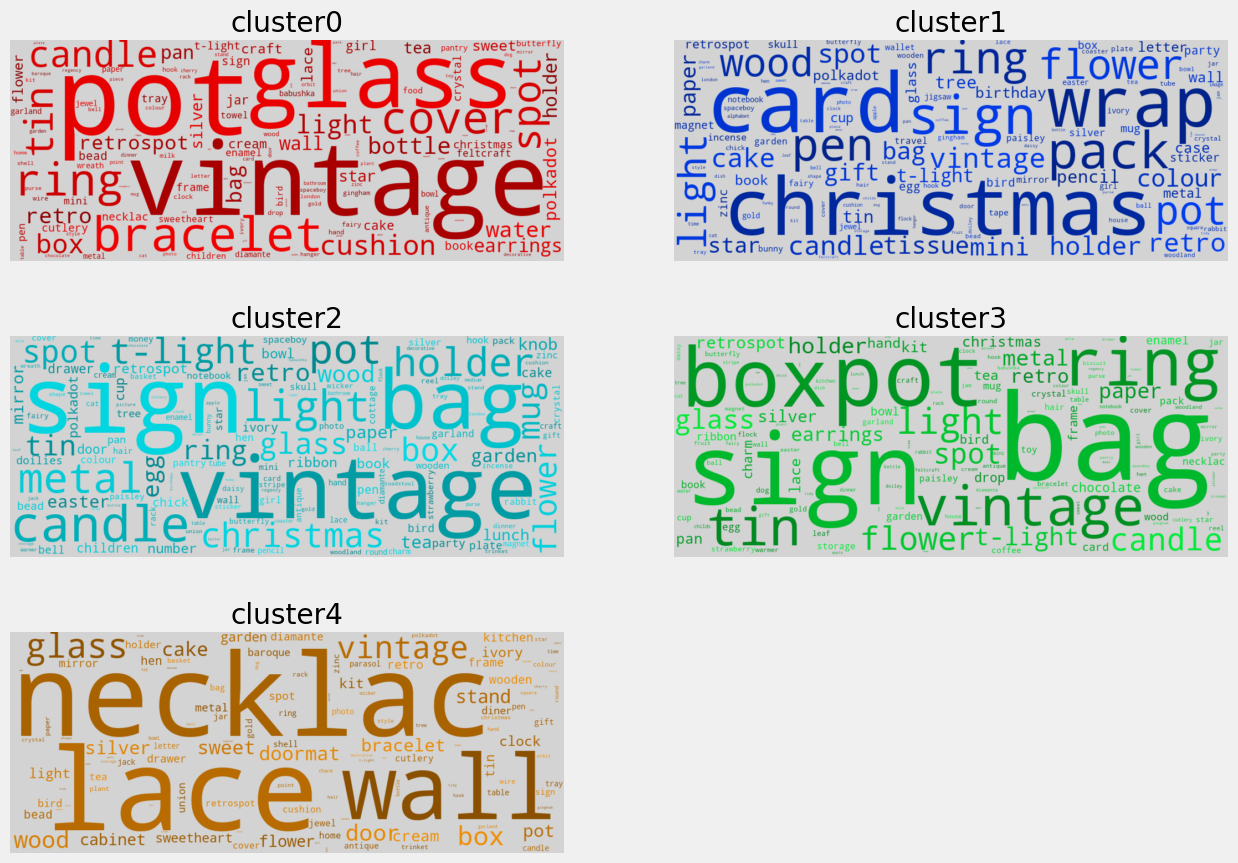

In [20]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)     

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

**c / _Principal Component Analysis_**

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:


In [21]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

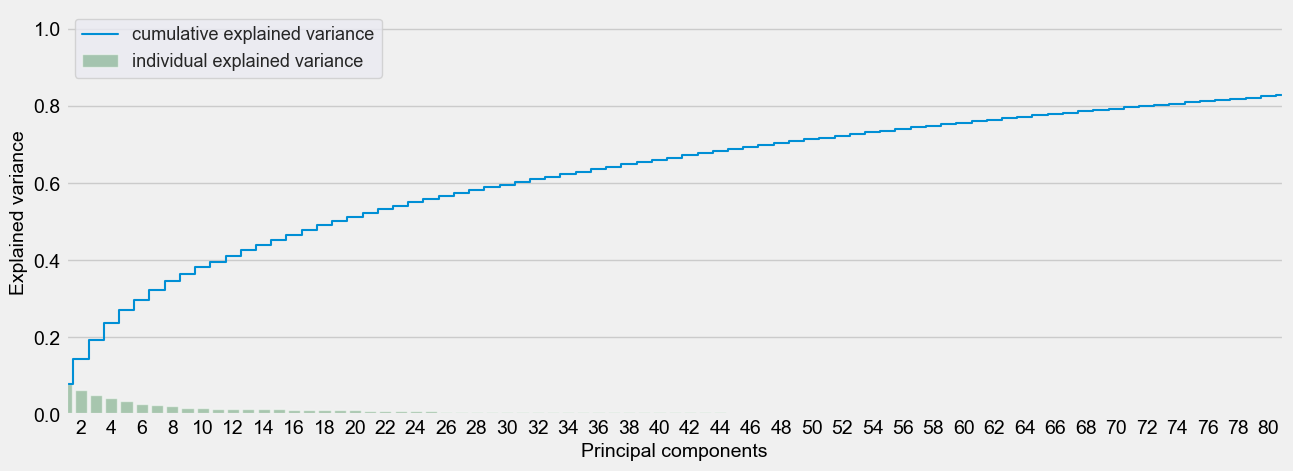

In [22]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 80)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [23]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

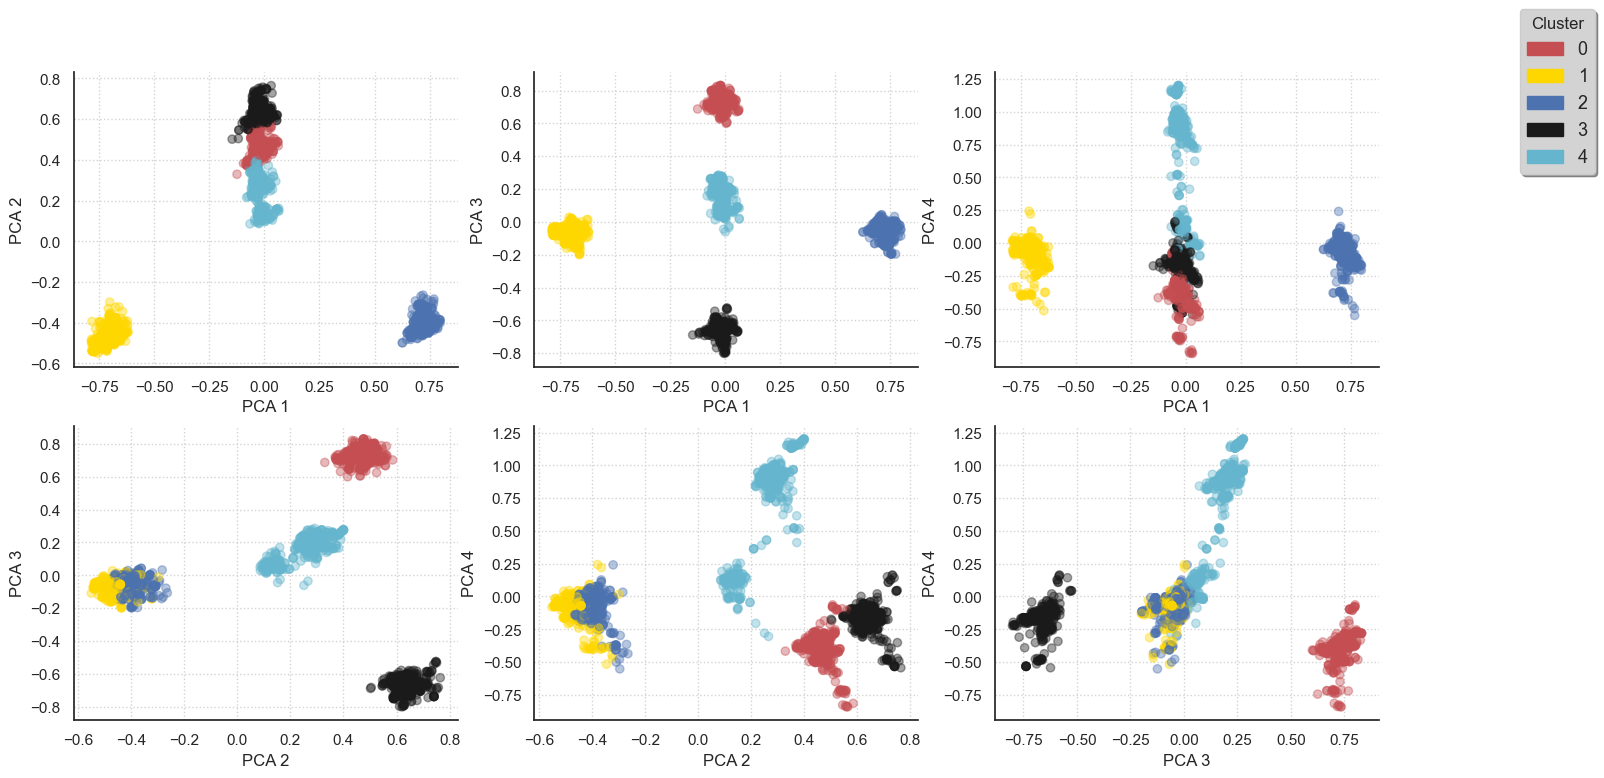

In [24]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

#  Customer categories

## Formatting data¶
In a second step, I decide to create the **categ_N** variables (with N∈[0:4]) that contains the amount spent in each product category: 




In [123]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [124]:
df_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0


In [125]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.00,0.0,0.0,15.3,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0


In [126]:

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp.iloc[:,2]

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346,541431,77183.60,0.00,0.00,77183.6,0.00,0.00,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,293.35,23.40,187.2,83.40,124.44,2010-12-07 14:57:00.000000000
3,12347,542237,475.39,169.20,84.34,130.5,53.10,38.25,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,115.00,81.00,330.9,71.10,38.25,2011-04-07 10:43:00.000000000
5,12347,556201,382.52,168.76,41.40,74.4,78.06,19.90,2011-06-09 13:01:00.000000000


In [127]:
basket_price['InvoiceDate_int'] = basket_price['InvoiceDate'].astype('int64')

In [30]:
temp.iloc[2]

CustomerID                         12347
InvoiceNo                         537626
InvoiceDate_int    1291733820000000000.0
Name: 2, dtype: object

In [128]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011,11,8)]
set_test2         = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011,11,8)]
basket_price = set_entrainement.copy(deep = True)

In [129]:

transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)
transactions_train=transactions_per_user.copy()

In [84]:
customer_train=pd.merge(transactions_per_user,train_FRM,on=["CustomerID"],how="outer")
customer_train.iloc[1:10,:]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,recency_log,frequency_log,monetaryValue_log
1,12347,6,382.52,1294.32,680.863333,4085.18,31.166069,10.911147,25.359960,20.592973,11.969852,2.079442,1.791759,8.315121
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,0.000000,20.030714,3.784190,1.386294,7.494007
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.692584,48.444976,27.900718,11.961722,5.631212,0.000000,5.812338
4,12352,8,120.33,840.30,313.255000,2506.04,14.492985,1.237011,17.747522,5.288423,61.234059,1.609438,2.079442,7.826459
5,12353,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,13.033708,19.887640,67.078652,5.153292,0.000000,4.488636
6,12354,1,1079.40,1079.40,1079.400000,1079.40,19.700760,14.950899,32.621827,9.380211,23.346304,5.303305,0.000000,6.984161
7,12355,1,459.40,459.40,459.400000,459.40,25.272094,0.000000,53.286896,11.558555,9.882455,5.209486,0.000000,6.129921
8,12356,2,481.46,2271.62,1376.540000,2753.08,7.409883,14.447455,28.656995,12.854694,36.630973,5.365976,0.693147,7.920476
9,12357,1,6207.67,6207.67,6207.670000,6207.67,28.350089,5.089832,18.098578,15.061690,33.399810,0.693147,0.000000,8.733541


In [85]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1551/4055  (38.25%)


## Creation of customers categories
### Data encoding
The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:



In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I create a matrix where these data are standardized:



In [86]:
customer_train=customer_train.dropna(how = 'any')

In [87]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4','recency_log','frequency_log','monetaryValue_log']
#_____________________________________________________________
selected_customers = customer_train.copy(deep = True)
matrix = selected_customers[list_cols].values

In [88]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.85548705 276.79899186 612.03607694 406.23887878  16.7528486
  13.94113265  25.28889163  21.17846043  22.83866668   3.84330043
   0.86156606   6.5175552 ]


In [89]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:


Additionally, I represent the amount of variance explained by each of the components:


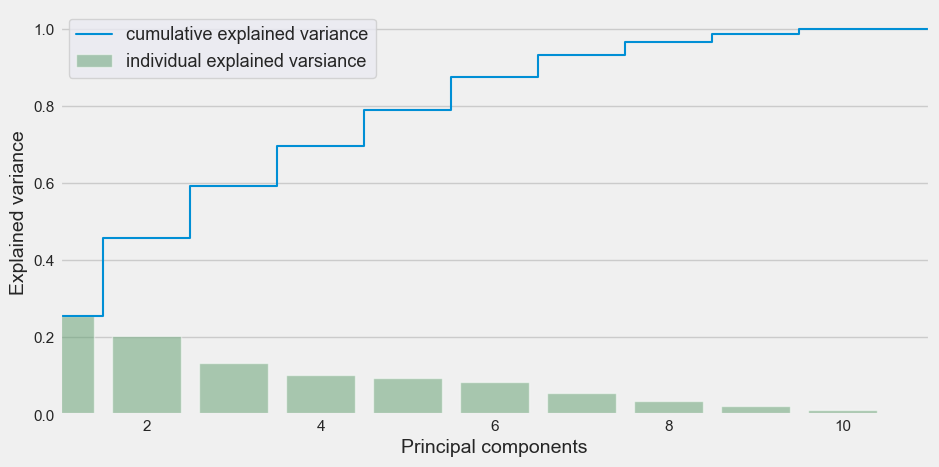

In [90]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained varsiance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

To find the best k for our k-means model, we consider the following scores and choose k=8

In [91]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [92]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
print(82 * "_")
print("k=\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
for i in range (4,15):
    kmeans = KMeans(init='k-means++', n_clusters = i, random_state=60,max_iter = 60)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    bench_k_means(kmeans=kmeans, name=str(i), data=scaled_matrix, labels=clusters_clients)
print(82 * "_")

__________________________________________________________________________________
k=		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
4        	0.154s	29154	1.000	1.000	1.000	1.000	1.000	0.147
5        	0.165s	26639	1.000	1.000	1.000	1.000	1.000	0.166
6        	0.238s	24367	1.000	1.000	1.000	1.000	1.000	0.161
7        	0.199s	22121	1.000	1.000	1.000	1.000	1.000	0.168
8        	0.268s	20188	1.000	1.000	1.000	1.000	1.000	0.213
9        	0.307s	18829	1.000	1.000	1.000	1.000	1.000	0.163
10       	0.448s	17744	1.000	1.000	1.000	1.000	1.000	0.185
11       	0.238s	16694	1.000	1.000	1.000	1.000	1.000	0.182
12       	0.293s	15901	1.000	1.000	1.000	1.000	1.000	0.170
13       	0.325s	15292	1.000	1.000	1.000	1.000	1.000	0.166
14       	0.290s	14785	1.000	1.000	1.000	1.000	1.000	0.165
__________________________________________________________________________________


In [93]:
n_clusters =8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters,max_iter = 600)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.195


At first, I look at the number of customers in each cluster: 



In [94]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,7,1,4,0,6,5,3,2
nb. de clients,1179,956,618,599,409,262,31,1


remove outlinnr in group 2 and 3

In [95]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

**a / _Report via the PCA_**

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:


in order to create a representation of the various clusters:


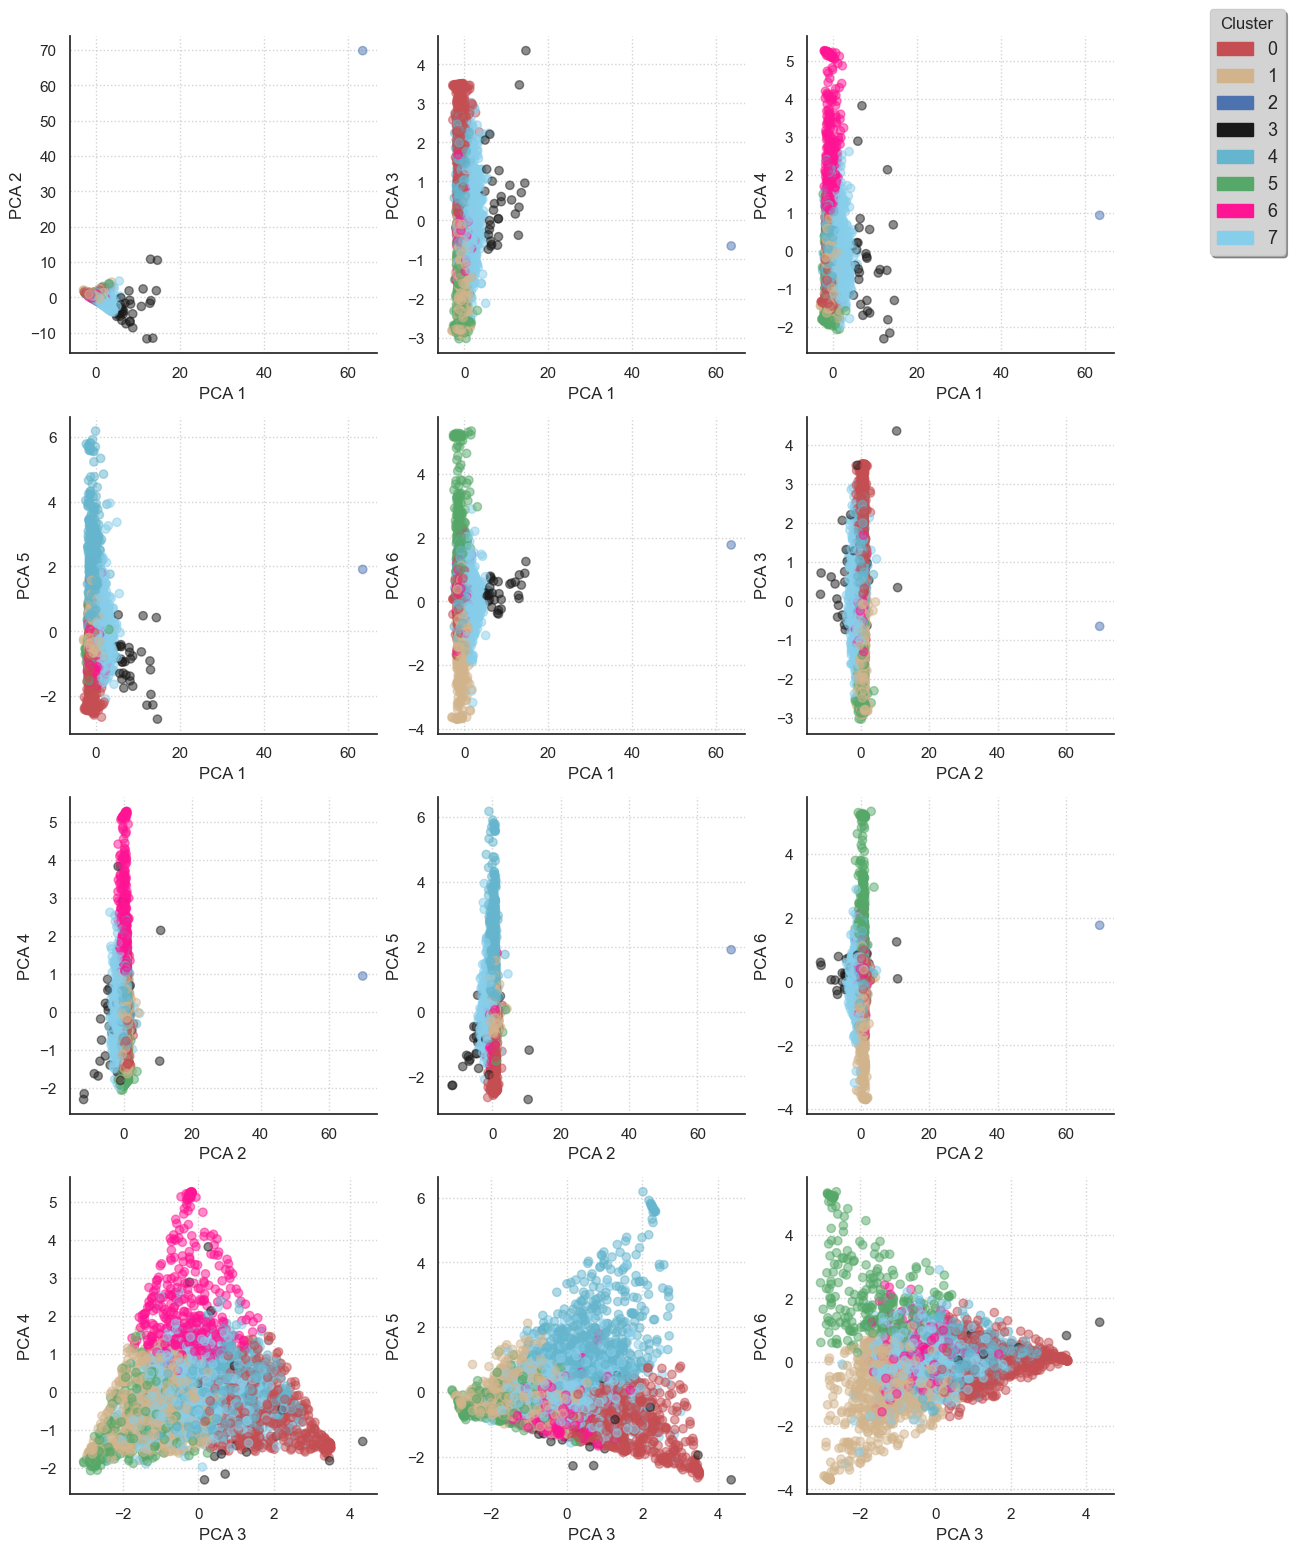

In [96]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,18))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:



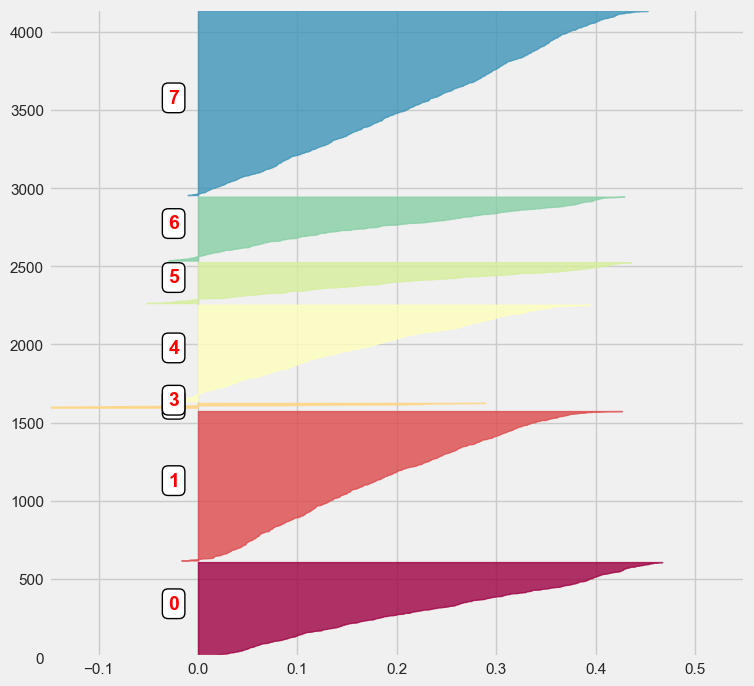

In [97]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [98]:
selected_customers.loc[:, 'cluster'] = clusters_clients


In [99]:
selected_customers.to_csv("kmeans_train.csv",index=False)

In [100]:
selected_customers=selected_customers[selected_customers.cluster!=2]
selected_customers=selected_customers[selected_customers.cluster!=4]
selected_customers=selected_customers[selected_customers.cluster!=3]
selected_customers.to_csv("kmeans_train_2.csv",index=False)

In [101]:
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,recency_log,frequency_log,monetaryValue_log,cluster
1,12347,6,382.52,1294.32,680.863333,4085.18,31.166069,10.911147,25.359960,20.592973,11.969852,2.079442,1.791759,8.315121,7
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,0.000000,20.030714,3.784190,1.386294,7.494007,1
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.692584,48.444976,27.900718,11.961722,5.631212,0.000000,5.812338,1
4,12352,8,120.33,840.30,313.255000,2506.04,14.492985,1.237011,17.747522,5.288423,61.234059,1.609438,2.079442,7.826459,7
5,12353,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,13.033708,19.887640,67.078652,5.153292,0.000000,4.488636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050,18280,1,180.60,180.60,180.600000,180.60,24.833887,0.000000,0.000000,41.140642,34.025471,5.505332,0.000000,5.196285,6
4051,18281,1,80.82,80.82,80.820000,80.82,0.000000,18.708241,20.415739,18.930958,41.945063,5.003946,0.000000,4.392224,0
4052,18282,1,100.21,100.21,100.210000,100.21,13.471709,20.516914,22.901906,17.662908,25.446562,4.553877,0.000000,4.607268,1
4053,18283,11,2.50,192.80,109.074545,1199.82,8.176226,16.740011,35.843710,34.176793,5.063259,2.484907,2.397895,7.119085,7


## Inspect the clusters with boxplot

<Figure size 640x480 with 0 Axes>

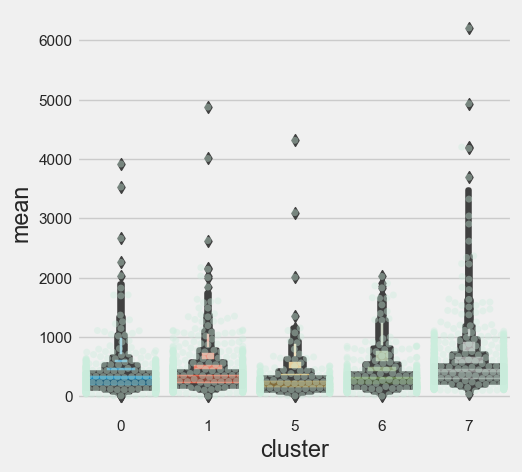

In [102]:
plt.figure()
pl = plt.figure(figsize = (5,5))
pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["mean"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["mean"])
plt.show()

<Figure size 640x480 with 0 Axes>

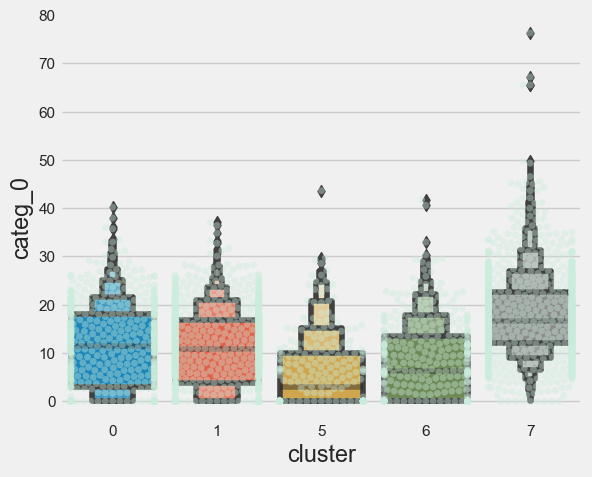

In [103]:
plt.figure()
pl = plt.figure(figsize = (6,5))
pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["categ_0"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["categ_0"])
plt.show()

<Figure size 640x480 with 0 Axes>

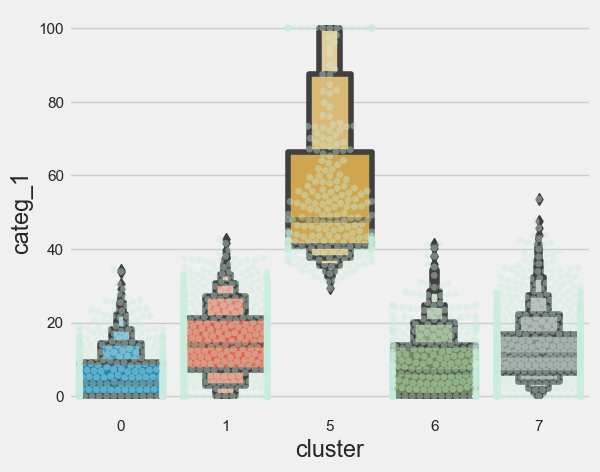

In [104]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["categ_1"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["categ_1"])
plt.show()

<Figure size 640x480 with 0 Axes>

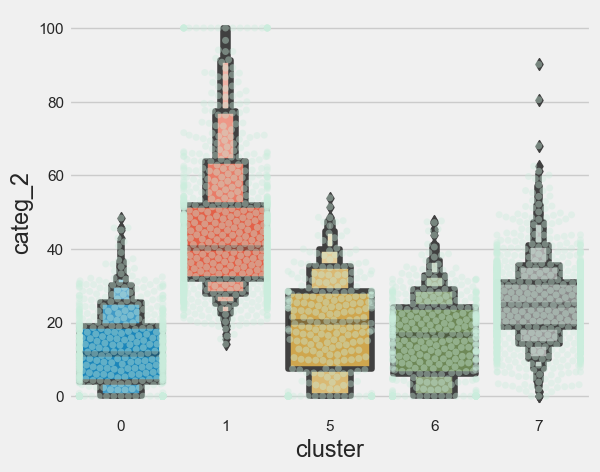

In [105]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["categ_2"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["categ_2"])
plt.show()

<Figure size 640x480 with 0 Axes>

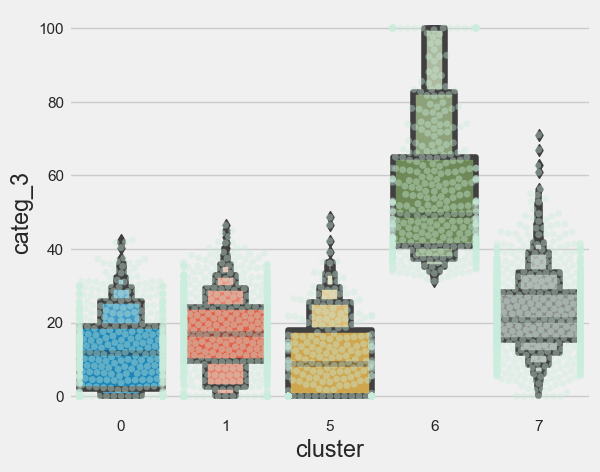

In [106]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["categ_3"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["categ_3"])
plt.show()

<Figure size 640x480 with 0 Axes>

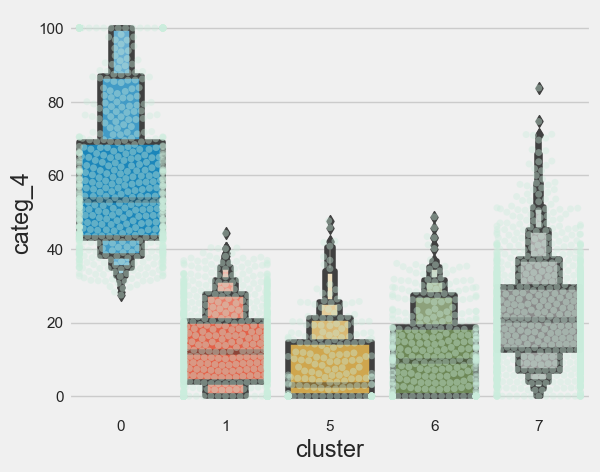

In [107]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers["categ_4"], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers["categ_4"])
plt.show()

<Figure size 640x480 with 0 Axes>

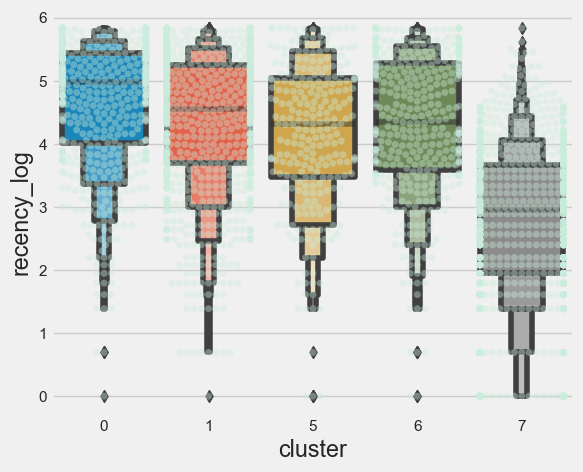

In [108]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers['recency_log'], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers['recency_log'])
plt.show()

<Figure size 640x480 with 0 Axes>

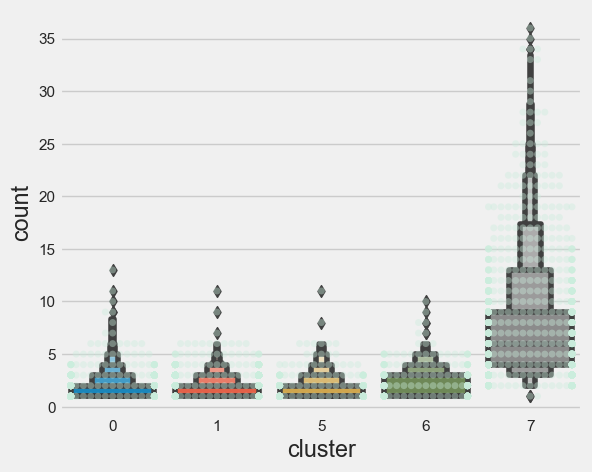

In [109]:
plt.figure()
pl = plt.figure(figsize = (6,5))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers['count'], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers['count'])
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

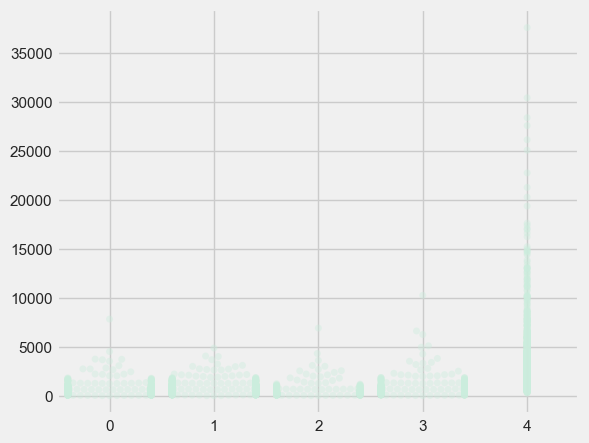

In [110]:
plt.figure()
pl = plt.figure(figsize = (6,5))
pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers['sum'], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers['sum'])
plt.show()

In [ ]:
plt.figure()
pl = plt.figure(figsize = (12,10))

pl=sns.swarmplot(x=selected_customers["cluster"], y=selected_customers['frequency_log'], color= "#CBEDDD", alpha=0.4 )
pl=sns.boxenplot(x=selected_customers["cluster"], y=selected_customers['frequency_log'])
plt.show()

In [ ]:
fig, ax =plt.subplots(1,3,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(x="species", y="sepal_length", data=iris, ax=ax[0])
axesSub.set_title('boxplot')
axesSub = sns.stripplot(x="species", y="sepal_length", data=iris, ax=ax[1])
axesSub.set_title('stripplot')
axesSub = sns.histplot(x="sepal_length", data=iris, ax=ax[2])
_ = axesSub.set_title('histplot')

In [ ]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(scaled_matrix)
kmeans = KMeans(init="k-means++", n_clusters=8, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
selected_customers.columns

## Hierarchical 
Hierarchical  method is also be considered. However, we do not choose this becasue of its poor performance

In [112]:

from sklearn.cluster import AgglomerativeClustering

In [114]:
for i in range (4,16):
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    Y_hc = hc.fit_predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, Y_hc)
   # print(silhouette_avg)
    print("For n_clusters =", i,'score de silhouette: {:<.3f}'.format(silhouette_avg))

For n_clusters = 4 score de silhouette: 0.132
For n_clusters = 5 score de silhouette: 0.102
For n_clusters = 6 score de silhouette: 0.119
For n_clusters = 7 score de silhouette: 0.130
For n_clusters = 8 score de silhouette: 0.131
For n_clusters = 9 score de silhouette: 0.139
For n_clusters = 10 score de silhouette: 0.141
For n_clusters = 11 score de silhouette: 0.134
For n_clusters = 12 score de silhouette: 0.102
For n_clusters = 13 score de silhouette: 0.099
For n_clusters = 14 score de silhouette: 0.093
For n_clusters = 15 score de silhouette: 0.089


In [115]:
for i in range (4,16):
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    Y_hc = hc.fit_predict(scaled_matrix)
    davies_avg = metrics.davies_bouldin_score(scaled_matrix, Y_hc)
    #print(davies_avg)
    print("For n_clusters =", i,'score de silhouette: {:<.3f}'.format(silhouette_avg))

For n_clusters = 4 score de silhouette: 0.089
For n_clusters = 5 score de silhouette: 0.089
For n_clusters = 6 score de silhouette: 0.089
For n_clusters = 7 score de silhouette: 0.089
For n_clusters = 8 score de silhouette: 0.089
For n_clusters = 9 score de silhouette: 0.089
For n_clusters = 10 score de silhouette: 0.089
For n_clusters = 11 score de silhouette: 0.089
For n_clusters = 12 score de silhouette: 0.089
For n_clusters = 13 score de silhouette: 0.089
For n_clusters = 14 score de silhouette: 0.089
For n_clusters = 15 score de silhouette: 0.089


## Test Set
We make the same manipulation in test set and keep it in another csv file. 

In [130]:
transactions_per_user=set_test2.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = set_test2.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[1:10]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
1,12349,1,1757.55,1757.55,1757.55,1757.55,10.713778,4.513101,26.506216,12.245455,46.021450
2,12356,1,58.35,58.35,58.35,58.35,0.000000,0.000000,0.000000,0.000000,100.000000
3,12358,1,683.20,683.20,683.20,683.20,0.000000,0.000000,3.425059,0.000000,96.574941
4,12362,1,529.04,529.04,529.04,529.04,35.120218,6.415394,15.896719,26.349614,16.218055
5,12364,1,310.32,310.32,310.32,310.32,0.000000,65.487239,23.975251,5.703790,4.833720
6,12367,1,168.90,168.90,168.90,168.90,5.861456,25.932504,41.563055,15.985790,10.657194
7,12374,1,742.93,742.93,742.93,742.93,10.956618,10.628188,25.233871,22.088218,31.093104
8,12375,1,227.20,227.20,227.20,227.20,0.000000,0.000000,0.000000,82.394366,17.605634
9,12380,1,1040.39,1040.39,1040.39,1040.39,17.082056,0.000000,11.908996,32.706004,38.302944


In [132]:
transactions_per_user=transactions_per_user.merge(transactions_train.CustomerID,on=['CustomerID'])
transactions_per_user

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,1,224.82,224.82,224.820,224.82,0.000000,17.160395,44.835869,24.659728,13.344009
1,12356,1,58.35,58.35,58.350,58.35,0.000000,0.000000,0.000000,0.000000,100.000000
2,12358,1,683.20,683.20,683.200,683.20,0.000000,0.000000,3.425059,0.000000,96.574941
3,12362,1,529.04,529.04,529.040,529.04,35.120218,6.415394,15.896719,26.349614,16.218055
4,12364,1,310.32,310.32,310.320,310.32,0.000000,65.487239,23.975251,5.703790,4.833720
...,...,...,...,...,...,...,...,...,...,...,...
1426,18263,1,401.76,401.76,401.760,401.76,0.000000,25.577459,64.068100,10.354440,0.000000
1427,18272,1,367.88,367.88,367.880,367.88,28.147766,0.000000,44.085028,22.915081,4.852126
1428,18273,1,51.00,51.00,51.000,51.00,0.000000,0.000000,0.000000,100.000000,0.000000
1429,18282,1,77.84,77.84,77.840,77.84,38.026721,6.474820,0.000000,22.738952,32.759507


In [131]:
test_FRM=pd.read_csv('data_RFM_test.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str},index_col=0)
customer_test=pd.merge(transactions_per_user,test_FRM,on=["CustomerID"],how="inner")
customer_test

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,recency_log,frequency_log,monetaryValue_log
0,12347,1,224.82,224.82,224.820,224.82,0.000000,17.160395,44.835869,24.659728,13.344009,0.693147,0.000000,8.315121
1,12356,1,58.35,58.35,58.350,58.35,0.000000,0.000000,0.000000,0.000000,100.000000,3.135494,0.000000,7.920476
2,12358,1,683.20,683.20,683.200,683.20,0.000000,0.000000,3.425059,0.000000,96.574941,0.693147,0.000000,6.183860
3,12362,1,529.04,529.04,529.040,529.04,35.120218,6.415394,15.896719,26.349614,16.218055,1.098612,0.000000,8.454720
4,12364,1,310.32,310.32,310.320,310.32,0.000000,65.487239,23.975251,5.703790,4.833720,2.079442,0.000000,6.910531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,18263,1,401.76,401.76,401.760,401.76,0.000000,25.577459,64.068100,10.354440,0.000000,3.258097,0.000000,6.698761
1427,18272,1,367.88,367.88,367.880,367.88,28.147766,0.000000,44.085028,22.915081,4.852126,1.098612,0.000000,7.904962
1428,18273,1,51.00,51.00,51.000,51.00,0.000000,0.000000,0.000000,100.000000,0.000000,0.693147,0.000000,5.030438
1429,18282,1,77.84,77.84,77.840,77.84,38.026721,6.474820,0.000000,22.738952,32.759507,2.079442,0.000000,4.607268


In [ ]:
customer_test.to_csv("kmeans_test_2.csv")

In [ ]:
customer_test